# Домашнее задание «Сверточные нейронные сети: практическое применение»


***Цель***:  Обучить модель классификации изображение на 2 класса.   

***Описание задания***: 
Классификация изображений: Cats vs Dogs.
Исходные данные и валидация решения на kaggle в рамках контеста Cats vs Dogs. Решения необходимо прислать в виде ipython-ноутбука с указанием значения метрики на Leaderboard. Задание засчитывается при значениях метрики Log Loss меньше 0.3.

### Загрузка данных:

In [1]:
import time
time_begin = time.time()

In [2]:
import cv2
import keras
import numpy as np
import tensorflow as tf
from keras import layers as L
from keras import backend as K
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications.resnet import ResNet50
from sklearn.metrics import accuracy_score
print(tf.__version__)
print(tf.executing_eagerly())

2.4.1
True


In [3]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('./train/*.jpg')
test_files = glob('./test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

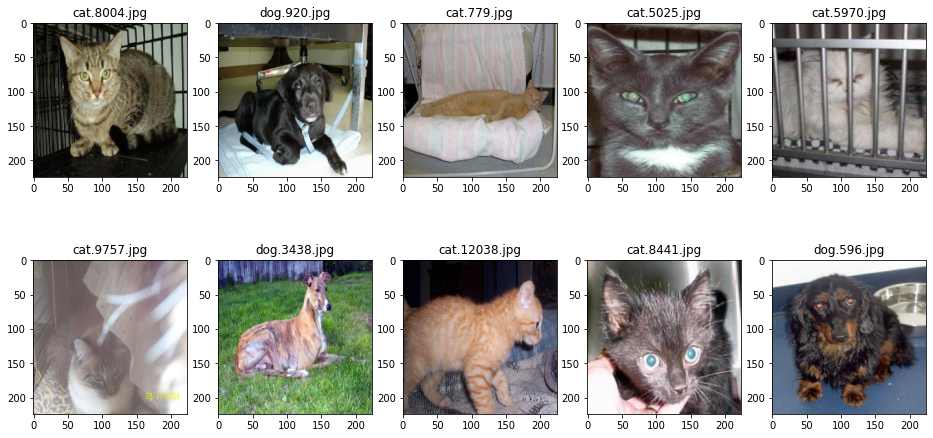

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

### Предобработка данных

Выделим несколько фотографий, которые будут валидацией и предобработаем снимки для "скармливания" модели:

In [5]:
val_samples = 2000  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

### Обучение модели

Инициализируем модель:

In [29]:
backbone = ResNet50(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), 
                 classes=2, 
                 include_top=False, 
                 weights='imagenet')  # используем сверточную сеть ResNet50

model = keras.Sequential()
model.add(backbone)
model.add(L.GlobalAveragePooling2D())    # уменьшим размерность
model.add(L.Flatten())                   # вытянем оставшееся в вектор

'''
Как оказалось в данном случае, чем проще, тем лучше :)
'''

# model.add(L.Dense(256, activation=L.LeakyReLU(alpha=0.0001)))  

# model.add(L.Dense(128, activation=L.LeakyReLU(alpha=0.0001)))  
# model.add(L.BatchNormalization(momentum=0.999, epsilon=0.00001))    # используем нормализацию
# model.add(L.Dropout(0.2))  

# model.add(L.Dense(128, activation=L.LeakyReLU(alpha=0.0001)))     # LeakyReLU в данном случае эффективнее
# model.add(L.BatchNormalization())    # используем нормализацию
# model.add(L.Dropout(0.2))   

# model.add(L.Dense(64, activation=L.LeakyReLU(alpha=0.0001)))
# model.add(L.BatchNormalization(momentum=0.999, epsilon=0.00001))    # используем нормализацию
# model.add(L.Dropout(0.3))                                           # используем регуляризацию


# model.add(L.Flatten())                            # вытягиваем в вектор
# model.add(L.Dense(32, activation='relu'))
# model.add(L.Dropout(0.3))
# model.add(L.Dense(32, activation='relu'))
# model.add(L.Dropout(0.5))


model.add(L.Dense(1, activation='sigmoid'))  # функция активации  
                          

opt_rms = keras.optimizers.RMSprop(lr=0.0002, decay=1e-6)
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss)
              metrics=['accuracy'])
model.build(input_shape=(None, 224, 224, 3))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________


In [30]:
callbacks = keras.callbacks.EarlyStopping(patience=4)

In [31]:
# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=20,  # число вызовов генератора за эпоху
          epochs=20,  # число эпох обучения
          callbacks=callbacks,
          validation_data=validation_data)

Epoch 1/20
20/20 [==============================] - 256s 13s/step - loss: 0.5698 - accuracy: 0.7636 - val_loss: 163444.0000 - val_accuracy: 0.5015
Epoch 2/20
20/20 [==============================] - 245s 13s/step - loss: 0.6640 - accuracy: 0.8170 - val_loss: 370810.7188 - val_accuracy: 0.4810
Epoch 3/20
20/20 [==============================] - 243s 12s/step - loss: 0.5921 - accuracy: 0.7685 - val_loss: 12714.3652 - val_accuracy: 0.5025
Epoch 4/20
20/20 [==============================] - 242s 12s/step - loss: 0.3088 - accuracy: 0.8781 - val_loss: 51.7922 - val_accuracy: 0.4980
Epoch 5/20
20/20 [==============================] - 242s 12s/step - loss: 0.2681 - accuracy: 0.8744 - val_loss: 17.1729 - val_accuracy: 0.5340
Epoch 6/20
20/20 [==============================] - 238s 12s/step - loss: 0.2189 - accuracy: 0.9208 - val_loss: 0.6548 - val_accuracy: 0.8430
Epoch 7/20
20/20 [==============================] - 240s 12s/step - loss: 0.2211 - accuracy: 0.9024 - val_loss: 1.3610 - val_accurac

In [32]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

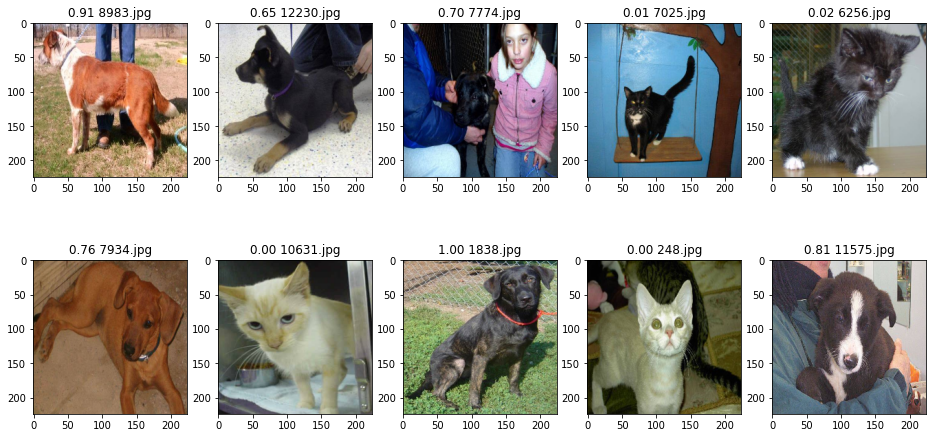

In [33]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

Итак, как видно на фото, ошибок нет.  
Можно сохранять в файл submit.txt:

In [34]:
import re

with open('submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

In [35]:
time_end = time.time()
print('Время расчёта, сек: {:.2f}'.format(time_end - time_begin))

Время расчёта, сек: 32730.63


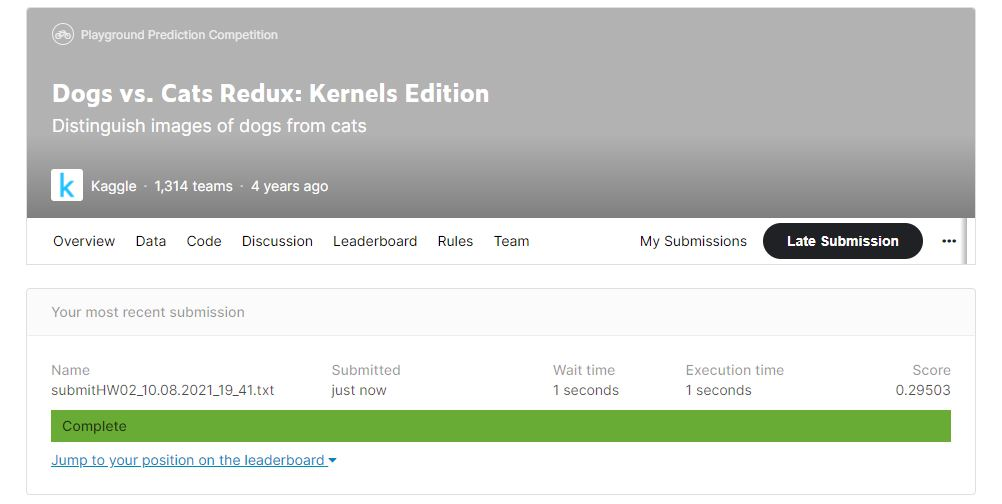

In [36]:
from IPython.display import Image
Image(filename='Kaggle_result.JPG')